In [1]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_selector, make_column_transformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold

import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.experimental.numpy as tnp
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import mean_squared_error

from functools import partial
from tqdm import tqdm
import datetime

In [2]:
my_seed=55
tqdm.pandas()

In [3]:
df_train = pd.read_csv('/kaggle/input/godaddy-microbusiness-density-forecasting/train.csv')
df_revealed = pd.read_csv('/kaggle/input/godaddy-microbusiness-density-forecasting/revealed_test.csv')
df_test = pd.read_csv('/kaggle/input/godaddy-microbusiness-density-forecasting/test.csv')
#df_test['first_day_of_month'] = pd.to_datetime(df_test["first_day_of_month"])

df_census = pd.read_csv('/kaggle/input/godaddy-microbusiness-density-forecasting/census_starter.csv')

df_state_loc= pd.read_csv('/kaggle/input/latitude-and-longitude-of-states-in-the-us/states.csv',  usecols=['name','latitude','longitude'])
df_state_loc.rename(columns={'name':'state','latitude':'state_latitude','longitude':'state_longitude'}, inplace=True)

df_county_loc= pd.read_csv('/kaggle/input/uscensus2022116thcongressionaldistricts/2022_Gaz_counties_national.csv',skipinitialspace=True, usecols=['GEOID','INTPTLAT','INTPTLONG'])
df_county_loc.rename(columns={'GEOID':'cfips', 'INTPTLAT':'county_latitude','INTPTLONG':'county_longitude'}, inplace=True)

In [4]:
(df_train.cfips.nunique(),df_test.cfips.nunique())

(3135, 3135)

In [5]:
df_revealed.describe(include='all')

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active
count,6270,6270.000000,6270,6270,6270,6270.000000,6.270000e+03
unique,6270,NaN,1871,51,2,NaN,NaN
top,1001_2022-11-01,NaN,Washington County,Texas,2022-11-01,NaN,NaN
freq,1,NaN,60,508,3135,NaN,NaN
mean,NaN,30376.037640,NaN,NaN,NaN,4.025670,6.818235e+03
std,NaN,15144.654548,NaN,NaN,NaN,6.239498,3.459636e+04
min,NaN,1001.000000,NaN,NaN,NaN,0.000000,0.000000e+00
25%,NaN,18177.500000,NaN,NaN,NaN,1.709230,1.510000e+02
50%,NaN,29173.000000,NaN,NaN,NaN,2.695358,5.145000e+02
75%,NaN,45076.500000,NaN,NaN,NaN,4.685238,2.213000e+03


In [6]:
df_train.describe(include='all')

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active
count,122265,122265.000000,122265,122265,122265,122265.000000,1.222650e+05
unique,122265,NaN,1871,51,39,NaN,NaN
top,1001_2019-08-01,NaN,Washington County,Texas,2019-08-01,NaN,NaN
freq,1,NaN,1170,9906,3135,NaN,NaN
mean,NaN,30376.037640,NaN,NaN,NaN,3.817671,6.442858e+03
std,NaN,15143.508721,NaN,NaN,NaN,4.991087,3.304001e+04
min,NaN,1001.000000,NaN,NaN,NaN,0.000000,0.000000e+00
25%,NaN,18177.000000,NaN,NaN,NaN,1.639344,1.450000e+02
50%,NaN,29173.000000,NaN,NaN,NaN,2.586543,4.880000e+02
75%,NaN,45077.000000,NaN,NaN,NaN,4.519231,2.124000e+03


In [7]:
df_geo_loc=df_train[["cfips","county","state","active"]].merge(df_state_loc, on='state').merge(df_county_loc,on='cfips', how='left')[["cfips","state_latitude","state_longitude","county_latitude","county_longitude"]]
df_geo_loc.drop_duplicates(inplace=True)
mask_county_latitude=pd.isnull(df_geo_loc['county_latitude'])
mask_county_longitude=pd.isnull(df_geo_loc['county_longitude'])
df_geo_loc.loc[mask_county_latitude,'county_latitude']=df_geo_loc.loc[mask_county_latitude,'state_latitude']
df_geo_loc.loc[mask_county_longitude,'county_longitude']=df_geo_loc.loc[mask_county_longitude,'state_latitude']

In [8]:
print(f"Train shape: {df_train.shape}")
print(f"Revealed shape: {df_revealed.shape}")
print(f"Test shape: {df_test.shape}")
print(f"Census shape: {df_census.shape}")
print(f"State Location shape: {df_state_loc.shape}")
print(f"County Location shape: {df_county_loc.shape}")
print(f"Geo Location shape: {df_geo_loc.shape}")

Train shape: (122265, 7)
Revealed shape: (6270, 7)
Test shape: (25080, 3)
Census shape: (3142, 26)
State Location shape: (52, 3)
County Location shape: (3222, 3)
Geo Location shape: (3135, 5)


In [9]:
states_by_region={'New England': ['Connecticut','Maine','Massachusetts','New Hampshire','Rhode Island','Vermont'],
'Mideast': ['Delaware','District of Columbia','Maryland', 'New Jersey','New York','Pennsylvania'],
'Great Lakes': ['Illinois', 'Indiana', 'Michigan','Ohio','Wisconsin'],
'Plains': ['Iowa','Kansas','Minnesota','Missouri','Nebraska','North Dakota', 'South Dakota'],
'Southeast':['Alabama','Arkansas','Florida','Georgia','Kentucky', 'Louisiana','Mississippi','North Carolina','South Carolina','Tennessee','Virginia','West Virginia'],
'Southwest': ['Arizona', 'New Mexico', 'Oklahoma', 'Texas'],
'Rocky Mountain': ['Colorado','Idaho','Montana','Utah','Wyoming'],
'Far West': ['Alaska','California','Hawaii','Nevada','Oregon','Washington']}

regions_by_state={s:r for r,states in states_by_region.items() for s in states  }
df_train['region']=df_train['state'].map(regions_by_state)
df_revealed['region']=df_revealed['state'].map(regions_by_state)

In [10]:
df_train['microbusiness_density']= df_train['microbusiness_density']
df_revealed['microbusiness_density']= df_revealed['microbusiness_density']

In [11]:
df_all_train=pd.concat([df_train,df_revealed])

In [12]:
#df_all_train=df_train.copy()

<AxesSubplot:>

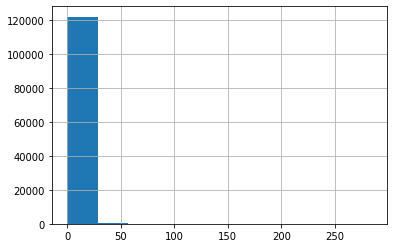

In [13]:
df_train['microbusiness_density'].hist()

<AxesSubplot:>

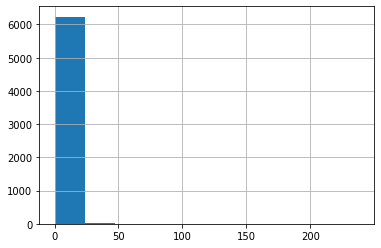

In [14]:
df_revealed['microbusiness_density'].hist()

In [15]:
df_train.groupby('region')['region'].count()

region
Far West           7098
Great Lakes       17043
Mideast            6942
New England        2613
Plains            24024
Rocky Mountain     8424
Southeast         41340
Southwest         14781
Name: region, dtype: int64

In [16]:
df_revealed.groupby('region')['region'].count()

region
Far West           364
Great Lakes        874
Mideast            356
New England        134
Plains            1232
Rocky Mountain     432
Southeast         2120
Southwest          758
Name: region, dtype: int64

## Reduce train data

In [17]:
REDUCE_SAMPLE=True

In [18]:
if  REDUCE_SAMPLE:
    #all_cfips=df_all_train.cfips.unique()
    all_cfips=df_all_train[df_all_train['active']>10].cfips.unique()
    np.random.seed(my_seed)
    np.random.shuffle(all_cfips)
    reduced_cfips=all_cfips[:250]
    df_train=df_all_train[df_all_train['cfips'].isin(reduced_cfips)]
    df_train
else:
    df_train=df_all_train
df_train

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,region
663,1035_2019-08-01,1035,Conecuh County,Alabama,2019-08-01,0.739241,73,Southeast
664,1035_2019-09-01,1035,Conecuh County,Alabama,2019-09-01,0.729114,72,Southeast
665,1035_2019-10-01,1035,Conecuh County,Alabama,2019-10-01,0.739241,73,Southeast
666,1035_2019-11-01,1035,Conecuh County,Alabama,2019-11-01,0.769620,76,Southeast
667,1035_2019-12-01,1035,Conecuh County,Alabama,2019-12-01,0.759494,75,Southeast
...,...,...,...,...,...,...,...,...
6213,55131_2022-12-01,55131,Washington County,Wisconsin,2022-12-01,6.380485,6751,Great Lakes
6256,56033_2022-11-01,56033,Sheridan County,Wyoming,2022-11-01,227.693980,54494,Rocky Mountain
6257,56033_2022-12-01,56033,Sheridan County,Wyoming,2022-12-01,238.060420,56975,Rocky Mountain
6262,56039_2022-11-01,56039,Teton County,Wyoming,2022-11-01,26.372364,5054,Rocky Mountain


# Cross Validation

In [19]:
ENABLE_CV=True

In [20]:
all_cfips=df_train.cfips.unique()
if ENABLE_CV:
    #train_cfips, valid_cfips=train_test_split(all_cfips, test_size=0.2,random_state=my_seed)
    train_cfips, valid_cfips=all_cfips,all_cfips[:int(0.1*len(all_cfips))]
    print(f"{(train_cfips.shape, valid_cfips.shape)}")
else:
    valid_cfips=[]
    train_cfips=all_cfips

((250,), (25,))


In [21]:
df_train_set=df_train[df_train['cfips'].isin(train_cfips)]
df_valid_set=df_train[df_train['cfips'].isin(valid_cfips)]
(df_train_set.shape,df_valid_set.shape)

((10250, 8), (1025, 8))

In [22]:
df_train['cfips'].nunique()

250

In [23]:
df_train_set['cfips'].nunique()

250

# PreProcessing

In [24]:
base_num_features=["pct_bb","pct_college","pct_foreign_born","pct_it_workers","median_hh_inc",'active']

In [25]:
class GeoLocationTransformer(TransformerMixin, BaseEstimator):        
        
    def fit(self, x, y=None):    
        return self   

    def transform(self, df, y=None):
        self.feature_names=['row_id','first_day_of_month','microbusiness_density','state', 'county' ,'active']    
        
        print(f'starting ge loc feature with input shape:  {df.shape}')        
        df = df.merge(df_geo_loc, on='cfips')   
        self.feature_names.extend(df_geo_loc.columns.values)   
        
        return  df[self.feature_names]
    
    def get_feature_names(self):
        return self.feature_names    

In [26]:
class CensorEnricher(TransformerMixin, BaseEstimator):        
        
    def fit(self, x, y=None):    
        return self   

    def transform(self, df, y=None):
        self.feature_names=[]    
        self.feature_names.extend(df.columns.values)     
                        
        print(f'starting censor feature with input shape:  {df.shape}')        
        df = df.merge(df_census, on='cfips')                     
        self.feature_names.extend(df_census.columns.values)                
        self.feature_names=set(self.feature_names)
        return  df[self.feature_names]
    
    def get_feature_names(self):
        return self.feature_names    

In [27]:
class TimeSeriesTransformer(TransformerMixin, BaseEstimator):        
        
    def fit(self, x, y=None):    
        return self   

    def transform(self, df, y=None):
        self.feature_names=[]    
        self.feature_names.extend(df.columns.values)     
        
        print(f'starting TS feature with input shape:  {df.shape} ')        
        
        df['first_day_of_month'] = pd.to_datetime(df["first_day_of_month"])
        df["year"] = df["first_day_of_month"].dt.year
        df['month'] = df["first_day_of_month"].dt.month
        
        self.feature_names.extend(['year','month'])    
        conditions = [df['year']==2019,df['year']==2020,df['year']==2021, df['year']==2022, df['year']==2023]
        features=base_num_features
        cols_to_delete=[]
        for feature in features:
            print(f"Processing feature: {feature}")
            if feature == 'active':
                continue
            wanted_cols=[c  for c in df.columns if feature in c]
            wanted_cols.sort()
            print(f"Wanted_cols: {wanted_cols}")
            cols_to_delete.extend(wanted_cols)
            choices=[ df[wc] for wc in wanted_cols ]            
            
            df[feature] = np.select(conditions, choices, default=np.nan)
            # remove redundant columns now 
            [ self.feature_names.remove(wc)  for wc in wanted_cols ]     
        
                           
        self.feature_names.extend(features)                
        
        self.feature_names=set(self.feature_names)
        return  df[self.feature_names]
    
    def get_feature_names(self):
        return self.feature_names    

In [28]:
class StateAndCountyAvgTransformer(TransformerMixin, BaseEstimator):        
        
    def fit(self, df, y=None):    
        self.fed_mean=df.groupby(['first_day_of_month'])['microbusiness_density'].mean().to_frame().rename(columns={'microbusiness_density':'fed_microbusiness_density'})
        self.state_mean=df.groupby(['first_day_of_month', 'state'])['microbusiness_density'].mean().to_frame().rename(columns={'microbusiness_density':'state_microbusiness_density'})

        return self   

    def transform(self, df, y=None):
        self.feature_names=[]    
        self.feature_names.extend(df.columns.values)        
        
        print(f'starting state and county avg feature with input shape:  {df.shape}')        
                
        df=df.merge(self.fed_mean,on=['first_day_of_month'])
        df=df.merge(self.state_mean,on=['first_day_of_month','state'], how='left')
        df['state_microbusiness_density']= np.where(pd.isnull(df['state_microbusiness_density']), df['fed_microbusiness_density'], df['state_microbusiness_density'])
        
        self.feature_names.extend(['fed_microbusiness_density','state_microbusiness_density'])   
        
        return  df[self.feature_names]
    
    def get_feature_names(self):
        return self.feature_names    

In [29]:
class RateTransformer1(TransformerMixin, BaseEstimator):        
        
    def fit(self, df, y=None):    
        return self   

    def transform(self, df, y=None):
        self.feature_names=[]    
        self.feature_names.extend(df.columns.values)        
        
        print(f'starting rate feature with input shape:  {df.shape}')        
        
        df.sort_values(['cfips','first_day_of_month'], inplace=True)                   
        df['rate_mbd']=df.groupby('cfips')['microbusiness_density'].shift(1)
        df['rate_mbd'] = df['rate_mbd']/df['microbusiness_density'] - 1
        df.loc[df['cfips']==28055, 'rate_mbd'] = 0.0
        df.loc[df['cfips']==48269, 'rate_mbd'] = 0.0
        df.loc[df['cfips']==48301, 'rate_mbd'] = 0.0

        self.feature_names.append('rate_mbd')   
        
        return  df[self.feature_names]
    
    def get_feature_names(self):
        return self.feature_names    

In [30]:
class RateTransformer(TransformerMixin, BaseEstimator):        
        
    def fit(self, df, y=None):    
        return self   

    def transform(self, df, y=None):
        self.feature_names=[]    
        self.feature_names.extend(df.columns.values)        
        
        print(f'starting rate feature with input shape:  {df.shape}')        
        
        df.sort_values(['cfips','first_day_of_month'], inplace=True)                   
        df['rate_mbd']=df.groupby('cfips')['microbusiness_density'].shift(1)
        df['rate_mbd'] = df['rate_mbd']/df['microbusiness_density'] - 1                
        #df.loc[df['cfips']==28055, 'rate_mbd'] = 0.0
        #df.loc[df['cfips']==48269, 'rate_mbd'] = 0.0
        #df.loc[df['cfips']==48301, 'rate_mbd'] = 0.0
        self.feature_names.append('rate_mbd')   
        
        for n in base_num_features:
            col_name=f'rate_{n}'
            df[col_name]=df.groupby('cfips')[n].shift(1)
            df[col_name] = df[col_name]/df[n] - 1  
            self.feature_names.append(col_name)   
        
        #df['mbd_S_1']=df.groupby('cfips')['microbusiness_density'].shift(1)
        #df['mbd_D_1']=df.groupby('cfips')['microbusiness_density'].shift(1).diff()
        #self.feature_names.extend(['mbd_S_1','mbd_D_1'])               
        
        return  df[self.feature_names]
    
    def get_feature_names(self):
        return self.feature_names    

In [31]:
class FillNAImputer1(TransformerMixin, BaseEstimator):        
        
    def fit(self, x, y=None):    
        return self   

    def transform(self, df, y=None):
        self.feature_names=[]    
        self.feature_names.extend(df.columns.values)     
                                    
        print(f'starting fill na imputer with input shape:  {df.shape}')                        
        # first fill zero values with NA 
        df.sort_values(['cfips','first_day_of_month'], inplace=True)           
        df[base_num_features]=df[base_num_features].mask(df[base_num_features]==0,np.nan)        
        df[base_num_features]=df.groupby('cfips')[base_num_features].fillna(method='ffill')
        df['rate_mbd']=df.groupby('cfips')['rate_mbd'].fillna(method='bfill')
        df[base_num_features]=df[base_num_features].mask(pd.isnull(df[base_num_features]),0)        

        return  df[self.feature_names]
    
    def get_feature_names(self):
        return self.feature_names    

In [32]:
class FillNAImputer(TransformerMixin, BaseEstimator):        
        
    def fit(self, x, y=None):    
        return self   

    def transform(self, df, y=None):
        self.feature_names=[]    
        self.feature_names.extend(df.columns.values)     
                                    
        print(f'starting fill na imputer with input shape:  {df.shape}')                        
        # first fill zero values with NA 
        df.sort_values(['cfips','first_day_of_month'], inplace=True) 
        rate_cols=[c for c in df.columns if "rate_" in c]
        cols=base_num_features+rate_cols 
        df[cols]=df[cols].mask(df[cols]==0,np.nan)        
        df[cols]=df.groupby('cfips')[cols].fillna(method='ffill')
        
        print(f'Filling na rate columns:{rate_cols} cols:{cols}')
        for c in rate_cols:
            print(f'Filling na rate column:{c}')
            df[c]=df.groupby('cfips')[c].fillna(method='bfill')            
        
        df[cols]=df[cols].mask(pd.isnull(df[cols]),0)        
        df[cols]=df[cols].mask(~np.isfinite(df[cols]),0)  
        df.dropna(inplace=True)
        
        return  df[self.feature_names]
    
    def get_feature_names(self):
        return self.feature_names  

In [33]:
rate_cols=[f'rate_{c}' for c in base_num_features ]
#num_features=['state_latitude', 'state_longitude', 'county_latitude', 'county_longitude']+ base_num_features
num_features=base_num_features
final_features=['microbusiness_density','fed_microbusiness_density','state_microbusiness_density'] + num_features + rate_cols
final_features

['microbusiness_density',
 'fed_microbusiness_density',
 'state_microbusiness_density',
 'pct_bb',
 'pct_college',
 'pct_foreign_born',
 'pct_it_workers',
 'median_hh_inc',
 'active',
 'rate_pct_bb',
 'rate_pct_college',
 'rate_pct_foreign_born',
 'rate_pct_it_workers',
 'rate_median_hh_inc',
 'rate_active']

In [34]:
def createPreprocessing():
    preprocessing=make_pipeline(GeoLocationTransformer(), 
                            CensorEnricher(),
                            TimeSeriesTransformer(),
                            StateAndCountyAvgTransformer(),
                            RateTransformer(),
                            FillNAImputer(), 
                            verbose=True)
    return preprocessing

In [35]:
preprocessing=createPreprocessing()
minMaxScalar=MinMaxScaler()

df_train_processed=preprocessing.fit_transform(df_train_set)
df_train_processed[num_features]=minMaxScalar.fit_transform(df_train_processed[num_features])
df_train_processed.set_index(['cfips','first_day_of_month'],inplace=True)

if ENABLE_CV:
    df_valid_processed=preprocessing.transform(df_valid_set)
    df_valid_processed[num_features]=minMaxScalar.transform(df_valid_processed[num_features])
    df_valid_processed.set_index(['cfips','first_day_of_month'],inplace=True)
else:
    df_valid_processed = None

starting ge loc feature with input shape:  (10250, 8)
[Pipeline]  (step 1 of 6) Processing geolocationtransformer, total=   0.0s
starting censor feature with input shape:  (10250, 11)
[Pipeline] .... (step 2 of 6) Processing censorenricher, total=   0.0s
starting TS feature with input shape:  (10250, 36) 
Processing feature: pct_bb
Wanted_cols: ['pct_bb_2017', 'pct_bb_2018', 'pct_bb_2019', 'pct_bb_2020', 'pct_bb_2021']
Processing feature: pct_college
Wanted_cols: ['pct_college_2017', 'pct_college_2018', 'pct_college_2019', 'pct_college_2020', 'pct_college_2021']
Processing feature: pct_foreign_born
Wanted_cols: ['pct_foreign_born_2017', 'pct_foreign_born_2018', 'pct_foreign_born_2019', 'pct_foreign_born_2020', 'pct_foreign_born_2021']
Processing feature: pct_it_workers
Wanted_cols: ['pct_it_workers_2017', 'pct_it_workers_2018', 'pct_it_workers_2019', 'pct_it_workers_2020', 'pct_it_workers_2021']
Processing feature: median_hh_inc
Wanted_cols: ['median_hh_inc_2017', 'median_hh_inc_2018',

In [36]:
df_train_processed['state'].unique()

array(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California',
       'Colorado', 'Connecticut', 'Delaware', 'Florida', 'Georgia',
       'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas',
       'Kentucky', 'Louisiana', 'Maryland', 'Massachusetts', 'Minnesota',
       'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
       'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon',
       'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota',
       'Tennessee', 'Texas', 'Utah', 'Virginia', 'Washington',
       'West Virginia', 'Wisconsin', 'Wyoming'], dtype=object)

In [37]:
df_valid_processed

state_longitude  county_longitude  pct_foreign_born  \
cfips first_day_of_month                                                        
1035  2019-08-01               -86.902298        -86.988722          0.020305   
      2019-09-01               -86.902298        -86.988722          0.020305   
      2019-10-01               -86.902298        -86.988722          0.020305   
      2019-11-01               -86.902298        -86.988722          0.020305   
      2019-12-01               -86.902298        -86.988722          0.020305   
...                                   ...               ...               ...   
8089  2022-08-01              -105.782067       -103.721260          0.111675   
      2022-09-01              -105.782067       -103.721260          0.111675   
      2022-10-01              -105.782067       -103.721260          0.111675   
      2022-11-01              -105.782067       -103.721260          0.111675   
      2022-12-01              -105.782067       -103.721260          0.111675   

                            active  year  pct_it_workers  state_latitude  \
cfips first_day_of_month                                                   
1035  2019-08-01          0.000137  2019        0.608696       32.318231   
      2019-09-01          0.000135  2019        0.608696       32.318231   
      2019-10-01          0.000137  2019        0.608696       32.318231   
      2019-11-01          0.000144  2019        0.608696       32.318231   
      2019-12-01          0.000142  2019        0.608696       32.318231   
...                            ...   ...             ...             ...   
8089  2022-08-01          0.000648  2022        0.586957       39.550051   
      2022-09-01          0.000657  2022        0.586957       39.550051   
      2022-10-01          0.000666  2022        0.586957       39.550051   
      2022-11-01          0.000668  2022        0.586957       39.550051   
      2022-12-01          0.000664  2022        0.586957       39.550051   

                          median_hh_inc  county_latitude    pct_bb  ...  \
cfips first_day_of_month                                            ...   
1035  2019-08-01               0.047558        31.430926  0.000000  ...   
      2019-09-01               0.047558        31.430926  0.000000  ...   
      2019-10-01               0.047558        31.430926  0.000000  ...   
      2019-11-01               0.047558        31.430926  0.000000  ...   
      2019-12-01               0.047558        31.430926  0.000000  ...   
...                                 ...              ...       ...  ...   
8089  2022-08-01               0.206979        37.884170  0.655678  ...   
      2022-09-01               0.206979        37.884170  0.655678  ...   
      2022-10-01               0.206979        37.884170  0.655678  ...   
      2022-11-01               0.206979        37.884170  0.655678  ...   
      2022-12-01               0.206979        37.884170  0.655678  ...   

                                   row_id  fed_microbusiness_density  \
cfips first_day_of_month                                               
1035  2019-08-01          1035_2019-08-01                   4.138585   
      2019-09-01          1035_2019-09-01                   4.135809   
      2019-10-01          1035_2019-10-01                   4.129840   
      2019-11-01          1035_2019-11-01                   4.162735   
      2019-12-01          1035_2019-12-01                   4.147996   
...                                   ...                        ...   
8089  2022-08-01          8089_2022-08-01                   4.537235   
      2022-09-01          8089_2022-09-01                   4.612613   
      2022-10-01          8089_2022-10-01                   5.022056   
      2022-11-01          8089_2022-11-01                   5.034878   
      2022-12-01          8089_2022-12-01                   5.109242   

                          state_microbusiness_density  rate_mbd rate_p

In [38]:
df_train_processed

state_longitude  county_longitude  pct_foreign_born  \
cfips first_day_of_month                                                        
1035  2019-08-01               -86.902298        -86.988722          0.020305   
      2019-09-01               -86.902298        -86.988722          0.020305   
      2019-10-01               -86.902298        -86.988722          0.020305   
      2019-11-01               -86.902298        -86.988722          0.020305   
      2019-12-01               -86.902298        -86.988722          0.020305   
...                                   ...               ...               ...   
56039 2022-08-01              -107.290284       -110.426087          0.289340   
      2022-09-01              -107.290284       -110.426087          0.289340   
      2022-10-01              -107.290284       -110.426087          0.289340   
      2022-11-01              -107.290284       -110.426087          0.289340   
      2022-12-01              -107.290284       -110.426087          0.289340   

                            active  year  pct_it_workers  state_latitude  \
cfips first_day_of_month                                                   
1035  2019-08-01          0.000137  2019        0.608696       32.318231   
      2019-09-01          0.000135  2019        0.608696       32.318231   
      2019-10-01          0.000137  2019        0.608696       32.318231   
      2019-11-01          0.000144  2019        0.608696       32.318231   
      2019-12-01          0.000142  2019        0.608696       32.318231   
...                            ...   ...             ...             ...   
56039 2022-08-01          0.011413  2022        0.326087       43.075968   
      2022-09-01          0.011416  2022        0.326087       43.075968   
      2022-10-01          0.011496  2022        0.326087       43.075968   
      2022-11-01          0.011539  2022        0.326087       43.075968   
      2022-12-01          0.011514  2022        0.326087       43.075968   

                          median_hh_inc  county_latitude    pct_bb  ...  \
cfips first_day_of_month                                            ...   
1035  2019-08-01               0.047558        31.430926  0.000000  ...   
      2019-09-01               0.047558        31.430926  0.000000  ...   
      2019-10-01               0.047558        31.430926  0.000000  ...   
      2019-11-01               0.047558        31.430926  0.000000  ...   
      2019-12-01               0.047558        31.430926  0.000000  ...   
...                                 ...              ...       ...  ...   
56039 2022-08-01               0.761606        44.048662  0.886447  ...   
      2022-09-01               0.761606        44.048662  0.886447  ...   
      2022-10-01               0.761606        44.048662  0.886447  ...   
      2022-11-01               0.761606        44.048662  0.886447  ...   
      2022-12-01               0.761606        44.048662  0.886447  ...   

                                    row_id  fed_microbusiness_density  \
cfips first_day_of_month                                                
1035  2019-08-01           1035_2019-08-01                   4.138585   
      2019-09-01           1035_2019-09-01                   4.135809   
      2019-10-01           1035_2019-10-01                   4.129840   
      2019-11-01           1035_2019-11-01                   4.162735   
      2019-12-01           1035_2019-12-01                   4.147996   
...                                    ...                        ...   
56039 2022-08-01          56039_2022-08-01                   4.537235   
      2022-09-01          56039_2022-09-01                   4.612613   
      2022-10-01          56039_2022-10-01                   5.022056   
      2022-11-01          56039_2022-11-01                   5.034878   
      2022-12-01          56039_2022-12-01                   5.109242   

                          state_microbusiness_density  ra

In [39]:
preprocessing=createPreprocessing()
df_all_train_processed=preprocessing.fit_transform(df_all_train)

minMaxScalar=MinMaxScaler()
df_all_train_processed[num_features]=minMaxScalar.fit_transform(df_all_train_processed[num_features])

df_all_train_processed.set_index(['cfips','first_day_of_month'],inplace=True)

starting ge loc feature with input shape:  (128535, 8)
[Pipeline]  (step 1 of 6) Processing geolocationtransformer, total=   0.1s
starting censor feature with input shape:  (128535, 11)
[Pipeline] .... (step 2 of 6) Processing censorenricher, total=   0.1s
starting TS feature with input shape:  (128535, 36) 
Processing feature: pct_bb
Wanted_cols: ['pct_bb_2017', 'pct_bb_2018', 'pct_bb_2019', 'pct_bb_2020', 'pct_bb_2021']
Processing feature: pct_college
Wanted_cols: ['pct_college_2017', 'pct_college_2018', 'pct_college_2019', 'pct_college_2020', 'pct_college_2021']
Processing feature: pct_foreign_born
Wanted_cols: ['pct_foreign_born_2017', 'pct_foreign_born_2018', 'pct_foreign_born_2019', 'pct_foreign_born_2020', 'pct_foreign_born_2021']
Processing feature: pct_it_workers
Wanted_cols: ['pct_it_workers_2017', 'pct_it_workers_2018', 'pct_it_workers_2019', 'pct_it_workers_2020', 'pct_it_workers_2021']
Processing feature: median_hh_inc
Wanted_cols: ['median_hh_inc_2017', 'median_hh_inc_201

In [40]:
df_all_train_processed

state_longitude  county_longitude  pct_foreign_born  \
cfips first_day_of_month                                                        
1001  2019-08-01               -86.902298         -86.64644          0.038889   
      2019-09-01               -86.902298         -86.64644          0.038889   
      2019-10-01               -86.902298         -86.64644          0.038889   
      2019-11-01               -86.902298         -86.64644          0.038889   
      2019-12-01               -86.902298         -86.64644          0.038889   
...                                   ...               ...               ...   
56045 2022-08-01              -107.290284        -104.57002          0.042593   
      2022-09-01              -107.290284        -104.57002          0.042593   
      2022-10-01              -107.290284        -104.57002          0.042593   
      2022-11-01              -107.290284        -104.57002          0.042593   
      2022-12-01              -107.290284        -104.57002          0.042593   

                            active  year  pct_it_workers  state_latitude  \
cfips first_day_of_month                                                   
1001  2019-08-01          0.001069  2019        0.074713       32.318231   
      2019-09-01          0.001025  2019        0.074713       32.318231   
      2019-10-01          0.001086  2019        0.074713       32.318231   
      2019-11-01          0.001064  2019        0.074713       32.318231   
      2019-12-01          0.001064  2019        0.074713       32.318231   
...                            ...   ...             ...             ...   
56045 2022-08-01          0.000085  2022        0.034483       43.075968   
      2022-09-01          0.000085  2022        0.034483       43.075968   
      2022-10-01          0.000085  2022        0.034483       43.075968   
      2022-11-01          0.000085  2022        0.034483       43.075968   
      2022-12-01          0.000086  2022        0.034483       43.075968   

                          median_hh_inc  county_latitude    pct_bb  ...  \
cfips first_day_of_month                                            ...   
1001  2019-08-01               0.282001        32.532237  0.717631  ...   
      2019-09-01               0.282001        32.532237  0.717631  ...   
      2019-10-01               0.282001        32.532237  0.717631  ...   
      2019-11-01               0.282001        32.532237  0.717631  ...   
      2019-12-01               0.282001        32.532237  0.717631  ...   
...                                 ...              ...       ...  ...   
56045 2022-08-01               0.266483        43.846213  0.760331  ...   
      2022-09-01               0.266483        43.846213  0.760331  ...   
      2022-10-01               0.266483        43.846213  0.760331  ...   
      2022-11-01               0.266483        43.846213  0.760331  ...   
      2022-12-01               0.266483        43.846213  0.760331  ...   

                                    row_id  fed_microbusiness_density  \
cfips first_day_of_month                                                
1001  2019-08-01           1001_2019-08-01                   3.749621   
      2019-09-01           1001_2019-09-01                   3.696846   
      2019-10-01           1001_2019-10-01                   3.778263   
      2019-11-01           1001_2019-11-01                   3.722510   
      2019-12-01           1001_2019-12-01                   3.717284   
...                                    ...                        ...   
56045 2022-08-01          56045_2022-08-01                   3.953798   
      2022-09-01          56045_2022-09-01                   3.959358   
      2022-10-01          56045_2022-10-01                   4.006963   
      2022-11-01          56045_2022-11-01                   4.014615   
      2022-12-01          56045_2022-12-01                   4.036725   

                          state_microbusiness_density  ra

In [41]:
pd.isnull(df_train_processed).sum(axis=0)

state_longitude                0
county_longitude               0
pct_foreign_born               0
active                         0
year                           0
pct_it_workers                 0
state_latitude                 0
median_hh_inc                  0
county_latitude                0
pct_bb                         0
microbusiness_density          0
month                          0
pct_college                    0
county                         0
state                          0
row_id                         0
fed_microbusiness_density      0
state_microbusiness_density    0
rate_mbd                       0
rate_pct_bb                    0
rate_pct_college               0
rate_pct_foreign_born          0
rate_pct_it_workers            0
rate_median_hh_inc             0
rate_active                    0
dtype: int64

In [42]:
if ENABLE_CV:
    pd.isnull(df_valid_processed).sum(axis=0)

In [43]:
df_train_processed[final_features]

microbusiness_density  fed_microbusiness_density  \
cfips first_day_of_month                                                     
1035  2019-08-01                       0.739241                   4.138585   
      2019-09-01                       0.729114                   4.135809   
      2019-10-01                       0.739241                   4.129840   
      2019-11-01                       0.769620                   4.162735   
      2019-12-01                       0.759494                   4.147996   
...                                         ...                        ...   
56039 2022-08-01                      26.085369                   4.537235   
      2022-09-01                      26.090586                   4.612613   
      2022-10-01                      26.273220                   5.022056   
      2022-11-01                      26.372364                   5.034878   
      2022-12-01                      26.314966                   5.109242   

                          state_microbusiness_density    pct_bb  pct_college  \
cfips first_day_of_month                                                       
1035  2019-08-01                             3.524903  0.000000     0.031609   
      2019-09-01                             3.528114  0.000000     0.031609   
      2019-10-01                             3.526904  0.000000     0.031609   
      2019-11-01                             3.573849  0.000000     0.031609   
      2019-12-01                             3.563771  0.000000     0.031609   
...                                               ...       ...          ...   
56039 2022-08-01                            69.763530  0.886447     0.951149   
      2022-09-01                            77.176413  0.886447     0.951149   
      2022-10-01                           127.014935  0.886447     0.951149   
      2022-11-01                           127.033172  0.886447     0.951149   
      2022-12-01                           132.187693  0.886447     0.951149   

                          pct_foreign_born  pct_it_workers  median_hh_inc  \
cfips first_day_of_month                                                    
1035  2019-08-01                  0.020305        0.608696       0.047558   
      2019-09-01                  0.020305        0.608696       0.047558   
      2019-10-01                  0.020305        0.608696       0.047558   
      2019-11-01                  0.020305        0.608696       0.047558   
      2019-12-01                  0.020305        0.608696       0.047558   
...                                    ...             ...            ...   
56039 2022-08-01                  0.289340        0.326087       0.761606   
      2022-09-01                  0.289340        0.326087       0.761606   
      2022-10-01                  0.289340        0.326087       0.761606   
      2022-11-01                  0.289340        0.326087       0.761606   
      2022-12-01                  0.289340        0.326087       0.761606   

                            active  rate_pct_bb  rate_pct_college  \
cfips first_day_of_month                                            
1035  2019-08-01          0.000137    -0.137712         -0.267606   
      2019-09-01          0.000135    -0.137712         -0.267606   
      2019-10-01          0.000137    -0.137712         -0.267606   
      2019-11-01          0.000144    -0.137712         -0.267606   
      2019-12-01          0.000142    -0.137712         -0.267606   
...                            ...          ...               ...   
56039 2022-08-01          0.011413    -0.022447          0.045699   
      2022-09-01          0.011416    -0.022447          0.045699   
      2022-10-01          0.011496    -0.022447          0.045699   
      2022-11-01          0.011539    -0.022447          0.045699   
      2022-12-01          0.011514    -0.022447          0.045699   

                          rate_pct_foreign_born  rate_pct_it_workers  

In [44]:
df_valid_processed

state_longitude  county_longitude  pct_foreign_born  \
cfips first_day_of_month                                                        
1035  2019-08-01               -86.902298        -86.988722          0.020305   
      2019-09-01               -86.902298        -86.988722          0.020305   
      2019-10-01               -86.902298        -86.988722          0.020305   
      2019-11-01               -86.902298        -86.988722          0.020305   
      2019-12-01               -86.902298        -86.988722          0.020305   
...                                   ...               ...               ...   
8089  2022-08-01              -105.782067       -103.721260          0.111675   
      2022-09-01              -105.782067       -103.721260          0.111675   
      2022-10-01              -105.782067       -103.721260          0.111675   
      2022-11-01              -105.782067       -103.721260          0.111675   
      2022-12-01              -105.782067       -103.721260          0.111675   

                            active  year  pct_it_workers  state_latitude  \
cfips first_day_of_month                                                   
1035  2019-08-01          0.000137  2019        0.608696       32.318231   
      2019-09-01          0.000135  2019        0.608696       32.318231   
      2019-10-01          0.000137  2019        0.608696       32.318231   
      2019-11-01          0.000144  2019        0.608696       32.318231   
      2019-12-01          0.000142  2019        0.608696       32.318231   
...                            ...   ...             ...             ...   
8089  2022-08-01          0.000648  2022        0.586957       39.550051   
      2022-09-01          0.000657  2022        0.586957       39.550051   
      2022-10-01          0.000666  2022        0.586957       39.550051   
      2022-11-01          0.000668  2022        0.586957       39.550051   
      2022-12-01          0.000664  2022        0.586957       39.550051   

                          median_hh_inc  county_latitude    pct_bb  ...  \
cfips first_day_of_month                                            ...   
1035  2019-08-01               0.047558        31.430926  0.000000  ...   
      2019-09-01               0.047558        31.430926  0.000000  ...   
      2019-10-01               0.047558        31.430926  0.000000  ...   
      2019-11-01               0.047558        31.430926  0.000000  ...   
      2019-12-01               0.047558        31.430926  0.000000  ...   
...                                 ...              ...       ...  ...   
8089  2022-08-01               0.206979        37.884170  0.655678  ...   
      2022-09-01               0.206979        37.884170  0.655678  ...   
      2022-10-01               0.206979        37.884170  0.655678  ...   
      2022-11-01               0.206979        37.884170  0.655678  ...   
      2022-12-01               0.206979        37.884170  0.655678  ...   

                                   row_id  fed_microbusiness_density  \
cfips first_day_of_month                                               
1035  2019-08-01          1035_2019-08-01                   4.138585   
      2019-09-01          1035_2019-09-01                   4.135809   
      2019-10-01          1035_2019-10-01                   4.129840   
      2019-11-01          1035_2019-11-01                   4.162735   
      2019-12-01          1035_2019-12-01                   4.147996   
...                                   ...                        ...   
8089  2022-08-01          8089_2022-08-01                   4.537235   
      2022-09-01          8089_2022-09-01                   4.612613   
      2022-10-01          8089_2022-10-01                   5.022056   
      2022-11-01          8089_2022-11-01                   5.034878   
      2022-12-01          8089_2022-12-01                   5.109242   

                          state_microbusiness_density  rate_mbd rate_p

## Recurrent Neural Network

In [45]:
def to_windows(dataset, length):
    dataset = dataset.window(length, shift=1, drop_remainder=True)
    return dataset.flat_map(lambda window_ds: window_ds.batch(length))

In [46]:
def to_seq2seq_dataset(series, seq_length=24, ahead=8, target_col=0,
                       batch_size=32, shuffle=False, seed=None):
    ds = to_windows(tf.data.Dataset.from_tensor_slices(series), ahead + 1)    
    #ds = to_windows(ds, seq_length).map(lambda S: (S[:, 0], S[:, 1:, 1]))
    ds = to_windows(ds, seq_length).map(lambda S: (S[:, 0], S[:, 1:, target_col]))
    if shuffle:
        ds = ds.shuffle(8 * batch_size, seed=seed)
    return ds.batch(batch_size)

In [47]:
df_train_processed[final_features]

microbusiness_density  fed_microbusiness_density  \
cfips first_day_of_month                                                     
1035  2019-08-01                       0.739241                   4.138585   
      2019-09-01                       0.729114                   4.135809   
      2019-10-01                       0.739241                   4.129840   
      2019-11-01                       0.769620                   4.162735   
      2019-12-01                       0.759494                   4.147996   
...                                         ...                        ...   
56039 2022-08-01                      26.085369                   4.537235   
      2022-09-01                      26.090586                   4.612613   
      2022-10-01                      26.273220                   5.022056   
      2022-11-01                      26.372364                   5.034878   
      2022-12-01                      26.314966                   5.109242   

                          state_microbusiness_density    pct_bb  pct_college  \
cfips first_day_of_month                                                       
1035  2019-08-01                             3.524903  0.000000     0.031609   
      2019-09-01                             3.528114  0.000000     0.031609   
      2019-10-01                             3.526904  0.000000     0.031609   
      2019-11-01                             3.573849  0.000000     0.031609   
      2019-12-01                             3.563771  0.000000     0.031609   
...                                               ...       ...          ...   
56039 2022-08-01                            69.763530  0.886447     0.951149   
      2022-09-01                            77.176413  0.886447     0.951149   
      2022-10-01                           127.014935  0.886447     0.951149   
      2022-11-01                           127.033172  0.886447     0.951149   
      2022-12-01                           132.187693  0.886447     0.951149   

                          pct_foreign_born  pct_it_workers  median_hh_inc  \
cfips first_day_of_month                                                    
1035  2019-08-01                  0.020305        0.608696       0.047558   
      2019-09-01                  0.020305        0.608696       0.047558   
      2019-10-01                  0.020305        0.608696       0.047558   
      2019-11-01                  0.020305        0.608696       0.047558   
      2019-12-01                  0.020305        0.608696       0.047558   
...                                    ...             ...            ...   
56039 2022-08-01                  0.289340        0.326087       0.761606   
      2022-09-01                  0.289340        0.326087       0.761606   
      2022-10-01                  0.289340        0.326087       0.761606   
      2022-11-01                  0.289340        0.326087       0.761606   
      2022-12-01                  0.289340        0.326087       0.761606   

                            active  rate_pct_bb  rate_pct_college  \
cfips first_day_of_month                                            
1035  2019-08-01          0.000137    -0.137712         -0.267606   
      2019-09-01          0.000135    -0.137712         -0.267606   
      2019-10-01          0.000137    -0.137712         -0.267606   
      2019-11-01          0.000144    -0.137712         -0.267606   
      2019-12-01          0.000142    -0.137712         -0.267606   
...                            ...          ...               ...   
56039 2022-08-01          0.011413    -0.022447          0.045699   
      2022-09-01          0.011416    -0.022447          0.045699   
      2022-10-01          0.011496    -0.022447          0.045699   
      2022-11-01          0.011539    -0.022447          0.045699   
      2022-12-01          0.011514    -0.022447          0.045699   

                          rate_pct_foreign_born  rate_pct_it_workers  

In [48]:
def bacth_gen2(df, seq_start=0, seq_length=37, ahead=4, shuffe=True, seed=my_seed):    
    df=df.reset_index()
    cfips=df['cfips'].unique()
    #print(f"len {len(cfips)}")
    #df.sort_values(['first_day_of_month'], inplace=True)
    #df.set_index(['first_day_of_month', 'cfips'],inplace=True)    
    np.random.seed(seed)
    if shuffe:
        np.random.shuffle(cfips)
    i=0
    tf.random.set_seed(seed)
    results_ds=[]
    resultsX=np.zeros((len(cfips),seq_length,len(final_features)))
    resultsY=np.zeros((len(cfips),ahead))
    for i, cfip in enumerate(cfips):        
        df1= df[df.cfips==cfip].copy()
        df1.sort_values(['first_day_of_month'], inplace=True)
        #df1.set_index(['first_day_of_month'],inplace=True)
        seq_end=seq_start+seq_length
        dataX=df1.iloc[seq_start:seq_end,:][final_features].values
        dataY=df1.iloc[seq_end:seq_end+ahead,:]['microbusiness_density'].values
        resultsX[i]=dataX
        resultsY[i]=dataY.reshape((1,-1))    
        results_ds.append((resultsX,resultsY))
        #print(f"{i} {cfip} {resultsX[i].shape}  {resultsY[i].shape} {resultsX.shape}")
    #ds = tf.data.Dataset.from_tensor_slices((resultsX,resultsY))
    yield from results_ds       
    

In [49]:
from functools import partial
seq_length=32 if ENABLE_CV else 37
target_seq_length=4
batch_size=32
effective_batch_size=df_train_processed.reset_index()['cfips'].nunique()

gen_train=partial(bacth_gen2,df_train_processed,seq_length=seq_length, shuffe=True)

train_mulvar_ds = tf.data.Dataset.from_generator(
     gen_train,
     output_signature=(
         tf.TensorSpec(shape=(effective_batch_size,seq_length,len(final_features)), dtype=tf.float64),
         tf.TensorSpec(shape=(effective_batch_size,target_seq_length), dtype=tf.float64)))

if ENABLE_CV:
    effective_batch_size=df_valid_processed.reset_index()['cfips'].nunique()
    gen_valid=partial(bacth_gen2,df_valid_processed, seq_start=5, seq_length=seq_length, ahead=4, shuffe=False, seed=None)
    valid_mulvar_ds = tf.data.Dataset.from_generator(
         gen_valid,
         output_signature=(
             tf.TensorSpec(shape=(effective_batch_size,seq_length,len(final_features)), dtype=tf.float64),
             tf.TensorSpec(shape=(effective_batch_size,target_seq_length), dtype=tf.float64)))
else:
    valid_mulvar_ds = None

In [50]:

#train_X=bacth_gen2(df_train_processed, shuffe=False)
#print(len(train_X))
#for x in train_mulvar_ds:
#   print(f"{x[0].shape}  {x[1].shape} {type(x)}")
   #print(f"{x[0]}  {x[1]} {type(x)}")



In [70]:
tf.random.set_seed(my_seed)  # extra code – ensures reproducibility
mulvar_model = tf.keras.Sequential([
    #tf.keras.layers.SimpleRNN(64, return_sequences=True, input_shape=[None, len(final_features)]),    
    #tf.keras.layers.SimpleRNN(64, return_sequences=True),
    #tf.keras.layers.SimpleRNN(64),
    #tf.keras.layers.SimpleRNN(32, input_shape=[None, len(final_features)], dropout=0.1),        
    #tf.keras.layers.LSTM(32, input_shape=[None, len(final_features)]),        
    #tf.keras.layers.LSTM(32, input_shape=[None, len(final_features)]),        
    #tf.keras.layers.GRU(32, input_shape=[None, len(final_features)], dropout=0.1),        
    #tf.keras.layers.GRU(32, return_sequences=True, input_shape=[None, len(final_features)], dropout=0.1),        
    #tf.keras.layers.GRU(12),    
    #tf.keras.layers.Dense(target_seq_length)
    
    tf.keras.layers.GRU(128, return_sequences=True,  input_shape=[None, len(final_features)]),        
    tf.keras.layers.GRU(128,  input_shape=[None, len(final_features)]),        
    #tf.keras.layers.GRU(64, return_sequences=True),        
    #tf.keras.layers.GRU(40),   
    #tf.keras.layers.SimpleRNN(64),
    #tf.keras.layers.Dense(target_seq_length,kernel_initializer='he_uniform')
    tf.keras.layers.Dense(target_seq_length)
])

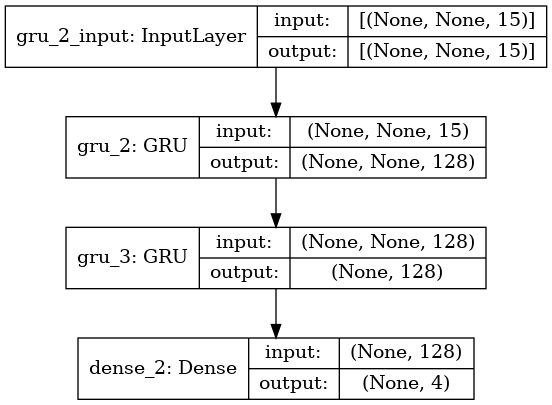

In [71]:
tf.keras.utils.plot_model(mulvar_model, "my_go_daddy.png", show_shapes=True)

In [58]:
def smape(y_true, y_pred):
    sym_sum = tf.abs(y_true) + tf.abs(y_pred)
    return 200 * tnp.nanmean(tf.abs(y_pred - y_true) /sym_sum )

In [59]:
def fit_and_evaluate(model, train_set, valid_set, learning_rate=0.01, epochs=100):
    monitor = "val_smape"  if ENABLE_CV else "smape"
    print(f"Early Stopping monitoring metrics: {monitor}")
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor="val_smape", patience=20, restore_best_weights=True)
    #opt = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    opt=tf.keras.optimizers.Adam(learning_rate=learning_rate)
    #model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=[smape])
    #model.compile(loss='mean_absolute_error', optimizer=opt, metrics=[smape])
    model.compile(loss='mean_squared_error', optimizer=opt, metrics=[smape])
    
    history = model.fit(train_set, validation_data=valid_set, epochs=epochs, callbacks=[early_stopping_cb], verbose=1)    
    
    if ENABLE_CV :
        valid_loss, valid_smape = model.evaluate(valid_set)
    else :
        valid_smape = np.min(history.history['smape'])
    return valid_smape 

In [60]:
#fit_and_evaluate(mulvar_model, train_mulvar_ds, valid_mulvar_ds, learning_rate=0.001, epochs=1000)
fit_and_evaluate(mulvar_model, train_mulvar_ds, valid_mulvar_ds, learning_rate=0.0001, epochs=10) ## increase epoch

Early Stopping monitoring metrics: val_smape
Epoch 1/20
250/250 [==============================] - 10s 32ms/step - loss: 63.7305 - smape: 63.6772 - val_loss: 16.8820 - val_smape: 44.7856
Epoch 2/20
250/250 [==============================] - 9s 32ms/step - loss: 53.5204 - smape: 22.2773 - val_loss: 11.6439 - val_smape: 23.2046
Epoch 3/20
250/250 [==============================] - 9s 32ms/step - loss: 49.8805 - smape: 12.8443 - val_loss: 8.2545 - val_smape: 17.2351
Epoch 4/20
250/250 [==============================] - 9s 31ms/step - loss: 47.1917 - smape: 9.4948 - val_loss: 5.7814 - val_smape: 12.4258
Epoch 5/20
250/250 [==============================] - 9s 32ms/step - loss: 44.9973 - smape: 7.5001 - val_loss: 3.9921 - val_smape: 9.2803
Epoch 6/20
250/250 [==============================] - 9s 32ms/step - loss: 43.1271 - smape: 6.1457 - val_loss: 2.7165 - val_smape: 7.1485
Epoch 7/20
250/250 [==============================] - 9s 34ms/step - loss: 41.4836 - smape: 5.2067 - val_loss: 1.7646

3.545379400253296

# Predict a sample 

4005
(1, 4)


,microbusiness_density,microbusiness_density
first_day_of_month,,
2019-08-01,6.231798,6.231798
2019-09-01,6.389821,6.389821
2019-10-01,6.436676,6.436676
2019-11-01,6.399927,6.399927
2019-12-01,6.366852,6.366852
2020-01-01,6.235868,6.235868
2020-02-01,6.157186,6.157186
2020-03-01,5.996201,5.996201
2020-04-01,6.055892,6.055892


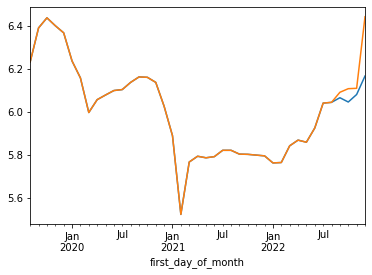

In [61]:
sample_cfips=df_train_processed.reset_index()['cfips'].unique()[5]
print(sample_cfips)
sample=df_train_processed.loc[(sample_cfips,),:]
#sample=df_all_train_processed.loc[(2013,),:]
y_all_act=sample.loc[:,'microbusiness_density']
y_all_pred=y_all_act.copy()
X= sample.loc[:,final_features].to_numpy()[np.newaxis,:-target_seq_length]
y_pred=mulvar_model.predict(X)#[0,-1,]
print(y_pred.shape)
months=sample.reset_index()['first_day_of_month'][-target_seq_length:]
y_all_pred.loc[months,]=y_pred
y_all_pred.plot()
y_all_act.plot()
pd.concat([y_all_pred,y_all_act], axis=1)

<AxesSubplot:xlabel='first_day_of_month'>

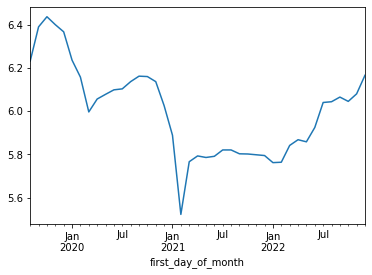

In [62]:
y_all_pred.plot()

<AxesSubplot:xlabel='first_day_of_month'>

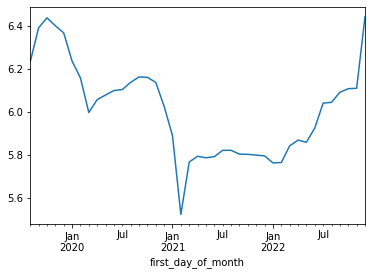

In [63]:
y_all_act.plot()

<AxesSubplot:>

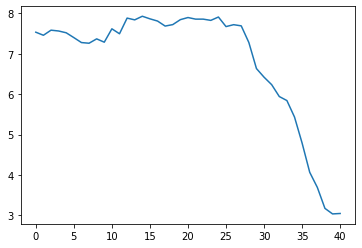

In [64]:
df_all_train[df_all_train['cfips']==6115].reset_index()['microbusiness_density'].plot()

# Run prediction for all training data

In [65]:
def predict(df):            
    df=df.reset_index()    
    cfips=df_test['cfips'].unique()
    res_pd=df_test.copy()
    res_pd.set_index(['cfips','first_day_of_month'], inplace=True)
    res_pd['microbusiness_density']=0.0

    print(f"len {len(cfips)}")
    i=0
    for cfip in tqdm(cfips):
        df1= df[df.cfips==cfip].copy()
        df1.sort_values(['first_day_of_month'], inplace=True)
        X= df1[final_features].to_numpy()[np.newaxis,4:]
        y_preds=mulvar_model.predict(X)
        y_preds=np.tile(y_preds,2)
        y_preds=y_preds[0]
    
        for j, date in enumerate(predicted_dates):          
            y_pred=y_preds[j]
            #print(f"{j} {date} {y_pred} ")
            res_pd.loc[(cfip,date),'microbusiness_density']=y_pred
        i=i+1
        
    return res_pd
predicted_dates=df_test['first_day_of_month'].unique()#[:target_seq_length]
predicted_dates.sort()
print(predicted_dates)
test_results=predict(df_all_train_processed)

test_results

['2022-11-01' '2022-12-01' '2023-01-01' '2023-02-01' '2023-03-01'
 '2023-04-01' '2023-05-01' '2023-06-01']
len 3135


100%|██████████| 3135/3135 [02:39<00:00, 19.65it/s]


,,row_id,microbusiness_density
cfips,first_day_of_month,,
1001,2022-11-01,1001_2022-11-01,3.389158
1003,2022-11-01,1003_2022-11-01,8.336554
1005,2022-11-01,1005_2022-11-01,1.157073
1007,2022-11-01,1007_2022-11-01,1.157782
1009,2022-11-01,1009_2022-11-01,1.717496
...,...,...,...
56037,2023-06-01,56037_2023-06-01,3.343079
56039,2023-06-01,56039_2023-06-01,28.990351
56041,2023-06-01,56041_2023-06-01,4.367271


# Prepare submission

In [66]:
test_results.microbusiness_density.describe()

count    25080.000000
mean         3.848723
std          3.856536
min         -1.400390
25%          1.614377
50%          2.619319
75%          4.657599
max         29.475620
Name: microbusiness_density, dtype: float64

<AxesSubplot:>

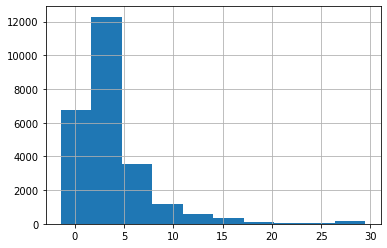

In [67]:
test_results.microbusiness_density.hist()

In [68]:
test_results.head()

,,row_id,microbusiness_density
cfips,first_day_of_month,,
1001,2022-11-01,1001_2022-11-01,3.389158
1003,2022-11-01,1003_2022-11-01,8.336554
1005,2022-11-01,1005_2022-11-01,1.157073
1007,2022-11-01,1007_2022-11-01,1.157782
1009,2022-11-01,1009_2022-11-01,1.717496


In [69]:
current_time =datetime.datetime.now().strftime("%y_%m_%d_%H_%M_%S")
test_results.sort_values(['cfips','first_day_of_month'],inplace=True)
test_results[['row_id','microbusiness_density']].to_csv(f'submission_{current_time}.csv', index=False)